# Debugging GridSearchXGB; GridSearchRF; LossAccuracyOverRounds; LossAccuracyOverEstimators; plotting

Using the iris dataset from sklearn

## Imports, root directory

In [2]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread


# import data handling tools
import numpy as np
import pandas as pd

#import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, log_loss

#sklearn imports
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import datasets

#import XGBoost
import xgboost as xgb

# import Deep Learning Libraries for feature extraction
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16

PROJECT_ROOT_DIR = "Results_Iris"

## GridSearch functions

For GridSearchXGBoost, we only use 10 estimators so that the GridSearch returns an optimal value that isn't in the corners of the heatmap (this was necessary for debugging the plotting of the rectangle in the heatmap)

In [4]:
def GridSearchXGboost(x_train, y_train, n_folds, eta_vals, lambda_vals):
    """
    defines a function to perform cross validation with n-folds over 
    a grid of values for the learning rate and the L2 regularization.
    
    x_train, y_train: features and targets of the training data (some of it is used for validation at each k-fold instance)
    n_folds: number of folds to perform cross validation
    eta_vals, lambda_vals: numpy arrays containing the desired Learning rates and L2 regs. for grid searching
    """
    param_grid = {"learning_rate" : eta_vals, "reg_lambda": lambda_vals}
    
    
    model = xgb.XGBClassifier(max_depth = 1, random_state = 123, n_estimators = 10)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_folds, scoring='accuracy', verbose=3)

    
    grid_search.fit(x_train, y_train)

    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "GridSearchXGB")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_csv = results_df.to_csv(FILE_PATH + "/crossval_XGB.csv")
    
    """
    saving the best accuracy score, (eta,lambda) pair  and its index for plotting and 
    for use in LossAccuracyOverRounds
    """
    
    test_array = np.zeros( ( len(eta_vals), len(lambda_vals) ) )
    
    best_acc = grid_search.best_score_
    best_params = grid_search.best_params_
    best_index =  np.unravel_index(grid_search.best_index_, test_array.shape)
    
    print(best_acc, best_params, best_index)
    
    with open(FILE_PATH + "/Best_settings_XGB.txt", "w") as file:
        file.write(f"Best value: L.R. = {best_params['learning_rate']}, L2 = {best_params['reg_lambda']}\n")
        file.write(f"Best validation accuracy: {best_acc}\n")
        file.write(f"Best indices: {best_index}")

    
def GridSearchRF(x_train, y_train, x_test, n_folds, depth_vals):
    param_grid = {"max_depth" : depth_vals}
    
    model = RandomForestClassifier(random_state = 123, criterion = "entropy", n_estimators = 100)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_folds, scoring='accuracy', verbose=3)

    grid_search.fit(x_train, y_train)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "GridSearchRF")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_csv = results_df.to_csv(FILE_PATH + "/crossval_RF.csv")

    """
    saving the best accuracy score, max_depth  and its index for plotting and 
    for use in LossAccuracyOverEstimators
    """
    
    test_array =  np.zeros(len(depth_vals))
    
    best_acc = grid_search.best_score_
    best_params = grid_search.best_params_
    best_index =  np.unravel_index(grid_search.best_index_, test_array.shape)
    
    print(best_acc, best_params, best_index)
    
    
    
    with open(FILE_PATH + "/Best_settings_RF.txt", "w") as file:
        file.write(f"Best value: Depth = {best_params['max_depth']}\n")
        file.write(f"Best validation accuracy: {best_acc}\n")
        file.write(f"Best indices: {best_index}")
           

## Loss Accuracy functions

In [6]:
def LossAccuracyOverRounds(x_train, y_train, x_test, y_test, eta, lamb, maxrounds):
    model = xgb.XGBClassifier(n_estimators = maxrounds, max_depth = 1, random_state = 123, objective = "multi:softmax", learning_rate = eta, reg_lambda = lamb)
    
    model.fit(x_train, y_train)

    train_preds, test_preds = [], []
    
    train_accs, test_accs = [], []
    
    train_errors, test_errors = [], []
    for i in range(1, maxrounds + 1):
        train_pred = model.predict(x_train, iteration_range = (0,i))
        train_pred_proba = model.predict_proba(x_train, iteration_range = (0,i))
        test_pred = model.predict(x_test, iteration_range = (0,i))
        test_pred_proba = model.predict_proba(x_test, iteration_range = (0,i))

        train_preds.append(train_pred)
        test_preds.append(test_pred)
        
    # Calculate log loss and accuracy for the current round
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        
        train_error = log_loss(y_train, train_pred_proba)
        train_errors.append(train_error)
        
        test_acc = accuracy_score(y_test, test_pred)
        test_accs.append(test_acc)
        
        test_error = log_loss(y_test, test_pred_proba)
        test_errors.append(test_error)
    
    train_accs, train_errors, test_accs, test_errors = np.array(train_accs), np.array(train_errors), np.array(test_accs), np.array(test_errors)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "LossAccuracyXGB")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)

    best_accuracy, best_iteration = max(test_accs), np.argmax(test_accs)
    final_accuracy_train, final_accuracy_test = train_accs[-1], test_accs[-1] 

    best_train_pred, best_test_pred = train_preds[best_iteration], test_preds[best_iteration]

    final_train_pred, final_test_pred = train_preds[-1], test_preds[-1]
    
    with open(FILE_PATH + "/Best_iteration_XGB.txt", "w") as file:
        file.write(f"Best iteration: Number = {best_iteration}, testing accuracy = {best_accuracy}\n")
        file.write(f"Final accuracies: Training = {final_accuracy_train}, testing = {final_accuracy_test}")
    
    np.save(FILE_PATH + '/train_accs_XGB.npy', train_accs)
    np.save(FILE_PATH + '/train_errors_XGB.npy', train_errors)
    np.save(FILE_PATH + '/test_accs_XGB.npy', test_accs)
    np.save(FILE_PATH + '/test_errors_XGB.npy', test_errors)

    np.save(FILE_PATH + '/best_train_XGB.npy', best_train_pred)
    np.save(FILE_PATH + '/best_test_XGB.npy', best_test_pred)
    np.save(FILE_PATH + '/final_train_XGB.npy', final_train_pred)
    np.save(FILE_PATH + '/final_test_XGB.npy', final_test_pred)
    
def LossAccuracyOverEstimators(x_train, y_train, x_test, y_test, depth, estimators):
    model = RandomForestClassifier(random_state = 123, max_depth = depth, n_estimators = estimators, criterion = 'entropy')
    
    model.fit(x_train, y_train)
    
    train_preds, test_preds = [], []
    
    train_accs, test_accs = [], []
    
    train_errors, test_errors = [], []
    for i in range(1, estimators+1):
        train_pred_proba = np.mean([tree.predict_proba(x_train) for tree in model.estimators_[:i]], axis=0)
        train_pred = np.argmax(train_pred_proba, axis = 1)
        
        test_pred_proba = np.mean([tree.predict_proba(x_test) for tree in model.estimators_[:i]], axis=0)
        test_pred = np.argmax(test_pred_proba, axis = 1)

        train_preds.append(train_pred)
        test_preds.append(test_pred)
        
    # Calculate log loss and accuracy for the current round
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        
        train_error = log_loss(y_train, train_pred_proba)
        train_errors.append(train_error)
        
        test_acc = accuracy_score(y_test, test_pred)
        test_accs.append(test_acc)
        
        test_error = log_loss(y_test, test_pred_proba)
        test_errors.append(test_error)
    
    train_accs, train_errors, test_accs, test_errors = np.array(train_accs), np.array(train_errors), np.array(test_accs), np.array(test_errors)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "LossAccuracyRF")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    best_accuracy, best_estimators = max(test_accs), np.argmax(test_accs)
    final_accuracy_train, final_accuracy_test = train_accs[-1], test_accs[-1] 

    best_train_pred, best_test_pred = train_preds[best_estimators], test_preds[best_estimators]

    final_train_pred, final_test_pred = train_preds[-1], test_preds[-1]
    
    with open(FILE_PATH + "/Best_estimators_RF.txt", "w") as file:
        file.write(f"Best n_estimators: Number = {best_estimators}, testing accuracy = {best_accuracy}\n")
        file.write(f"Final accuracies: Training = {final_accuracy_train}, testing = {final_accuracy_test}")    
    
    np.save(FILE_PATH + '/train_accs_RF.npy', train_accs)
    np.save(FILE_PATH + '/train_errors_RF.npy', train_errors)
    np.save(FILE_PATH + '/test_accs_RF.npy', test_accs)
    np.save(FILE_PATH + '/test_errors_RF.npy', test_errors)

    np.save(FILE_PATH + '/best_train_RF.npy', best_train_pred)
    np.save(FILE_PATH + '/best_test_RF.npy', best_test_pred)
    np.save(FILE_PATH + '/final_train_RF.npy', final_train_pred)
    np.save(FILE_PATH + '/final_test_RF.npy', final_test_pred)

## Cross-validation and entropy/loss over iterations for XGBoost

In [8]:
inputs, outputs = datasets.load_iris(return_X_y=True)

strat = outputs
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = .3, shuffle=True, stratify=strat, random_state=123)

eta_vals = np.linspace(0.05, 0.35, 7)
lambda_vals = np.logspace(-5, 0, 6)
lambda_vals = np.insert(lambda_vals, 0, 0)

GridSearchXGboost(x_train, y_train, 5, eta_vals, lambda_vals)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.952 total time=   0.0s
[CV 2/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.905 total time=   0.0s
[CV 3/5] END learning_rate=0.05, reg_lambda=0.0;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.952 total time=   0.0s
[CV 5/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.857 total time=   0.0s
[CV 1/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.952 total time=   0.0s
[CV 2/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.905 total time=   0.0s
[CV 3/5] END learning_rate=0.05, reg_lambda=1e-05;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.952 total time=   0.0s
[CV 5/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.857 total time=   0.0s
[CV 1/5] END learning_rate=0.05, reg_lambda=0.0001;, score=0.952 total time=   0.0s
[CV 2/5] END learning_rate=0.05, r

### Running LossAccuracyOverRounds

Changed the previous notebook to split the grid search from LossAccuracyOverRounds. Since the grid searching process for the actual dataset was much slower, being able to debug/re-run LossAccuracyOverRounds without having to repeat the grid search is very important.

In [10]:
with open('Results_Iris/GridSearchXGB/Best_settings_XGB.txt','r') as file:
    lines = file.readlines()
    optimalparamsXGB = [float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexXGB = [int(i) for i in lines[2].split(':')[1].lstrip(' (').rstrip(')').split(',')]

LossAccuracyOverRounds(x_train, y_train, x_test, y_test, optimalparamsXGB[0], optimalparamsXGB[1], 1000)

## Cross-validation and entropy/loss over estimators for Random Forest

In [12]:
depth_vals = [int(i) for i in np.linspace(1,6,6)]

GridSearchRF(x_train, y_train, x_test, 5, depth_vals)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .......................max_depth=1;, score=0.952 total time=   0.0s
[CV 2/5] END .......................max_depth=1;, score=0.905 total time=   0.0s
[CV 3/5] END .......................max_depth=1;, score=1.000 total time=   0.0s
[CV 4/5] END .......................max_depth=1;, score=0.952 total time=   0.0s
[CV 5/5] END .......................max_depth=1;, score=0.714 total time=   0.0s
[CV 1/5] END .......................max_depth=2;, score=0.905 total time=   0.0s
[CV 2/5] END .......................max_depth=2;, score=0.905 total time=   0.0s
[CV 3/5] END .......................max_depth=2;, score=0.952 total time=   0.0s
[CV 4/5] END .......................max_depth=2;, score=0.952 total time=   0.0s
[CV 5/5] END .......................max_depth=2;, score=1.000 total time=   0.0s
[CV 1/5] END .......................max_depth=3;, score=0.952 total time=   0.0s
[CV 2/5] END .......................max_depth=3;,

In [13]:
with open('Results_Iris/GridSearchRF/Best_settings_RF.txt','r') as file:
    lines = file.readlines()
    optimalparamsRF = [int(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]

LossAccuracyOverEstimators(x_train, y_train, x_test, y_test, optimalparamsRF[0], 1000)

## Plotting

We plot an accuracy heatmap, training and test confusion matrices and the cross-entropy/accuracy curves over iterations for XGBoost.

We plot the accuracy for different depths, training and test confusion matrices and the cross-entropy/accuracy curves over estimators for Random Forests

The produced files are reloaded so these cells can be reran without needing to cross-validate again.

In [113]:
PATH_1 = "Results_Iris/GridSearchRF"
PATH_2 = "Results_Iris/LossAccuracyRF"

CVdataframe_RF = pd.read_csv(PATH_1 + '/crossval_RF.csv')

with open(PATH_1 + '/Best_settings_RF.txt','r') as file:
    lines = file.readlines()
    optimalparamsRF = [int(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexRF = int(lines[2].split('(')[1].rstrip(',)'))

with open(PATH_2 + '/Best_estimators_RF.txt','r') as file:
    lines = file.readlines()
    optimal_estimatorsRF, optimal_accuracyRF = (float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(','))
    finaltrain_accuracyRF, finaltest_accuracyRF = (float(i.split('=')[1].rstrip('\n')) for i in lines[1].split(':')[1].split(','))

print(f"Random Forests: Optimal n_estimators: {optimal_estimatorsRF}, with a test accuracy of  {optimal_accuracyRF}")
print(f"Random Forests: Final training accuracy: {finaltrain_accuracyRF}, final test accuracy: {finaltest_accuracyRF}")

train_predictions_RF = np.load(PATH_2 + '/best_train_RF.npy')
test_predictions_RF = np.load(PATH_2 + '/best_test_RF.npy')

train_accs_RF, train_errors_RF = np.load(PATH_2 + '/train_accs_RF.npy'), np.load(PATH_2 + '/train_errors_RF.npy')
test_accs_RF, test_errors_RF = np.load(PATH_2 + '/test_accs_RF.npy'), np.load(PATH_2 + '/test_errors_RF.npy')

Random Forests: Optimal n_estimators: 7.0, with a test accuracy of  0.9777777777777777
Random Forests: Final training accuracy: 0.9809523809523809, final test accuracy: 0.9777777777777777


In [114]:
PATH_3 = "Results_Iris/GridSearchXGB"
PATH_4 = "Results_Iris/LossAccuracyXGB"

CVdataframe_XGB = pd.read_csv(PATH_3 + '/crossval_XGB.csv')

with open(PATH_3 + '/Best_settings_XGB.txt','r') as file:
    lines = file.readlines()
    optimalparamsXGB = [float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexXGB = [int(i) for i in lines[2].split(':')[1].lstrip(' (').rstrip(')').split(',')]

with open(PATH_4 + '/Best_iteration_XGB.txt','r') as file:
    lines = file.readlines()
    optimal_iterationXGB, optimal_accuracyXGB = (float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(','))
    finaltrain_accuracyXGB, finaltest_accuracyXGB = (float(i.split('=')[1].rstrip('\n')) for i in lines[1].split(':')[1].split(','))

print(f"XGBoost: Optimal iteration: {optimal_iterationXGB}, with a test accuracy of  {optimal_accuracyXGB}")
print(f"XGBoost: Final training accuracy: {finaltrain_accuracyXGB}, final test accuracy: {finaltest_accuracyXGB}")

train_predictions_XGB = np.load(PATH_4 + '/best_train_XGB.npy')
test_predictions_XGB = np.load(PATH_4 + '/best_test_XGB.npy')

train_accs_XGB, train_errors_XGB = np.load(PATH_4 + '/train_accs_XGB.npy'), np.load(PATH_4 + '/train_errors_XGB.npy')
test_accs_XGB, test_errors_XGB = np.load(PATH_4 + '/test_accs_XGB.npy'), np.load(PATH_4 + '/test_errors_XGB.npy')

XGBoost: Optimal iteration: 7.0, with a test accuracy of  0.9777777777777777
XGBoost: Final training accuracy: 1.0, final test accuracy: 0.9555555555555556


## Plots for RandomForestClassifier

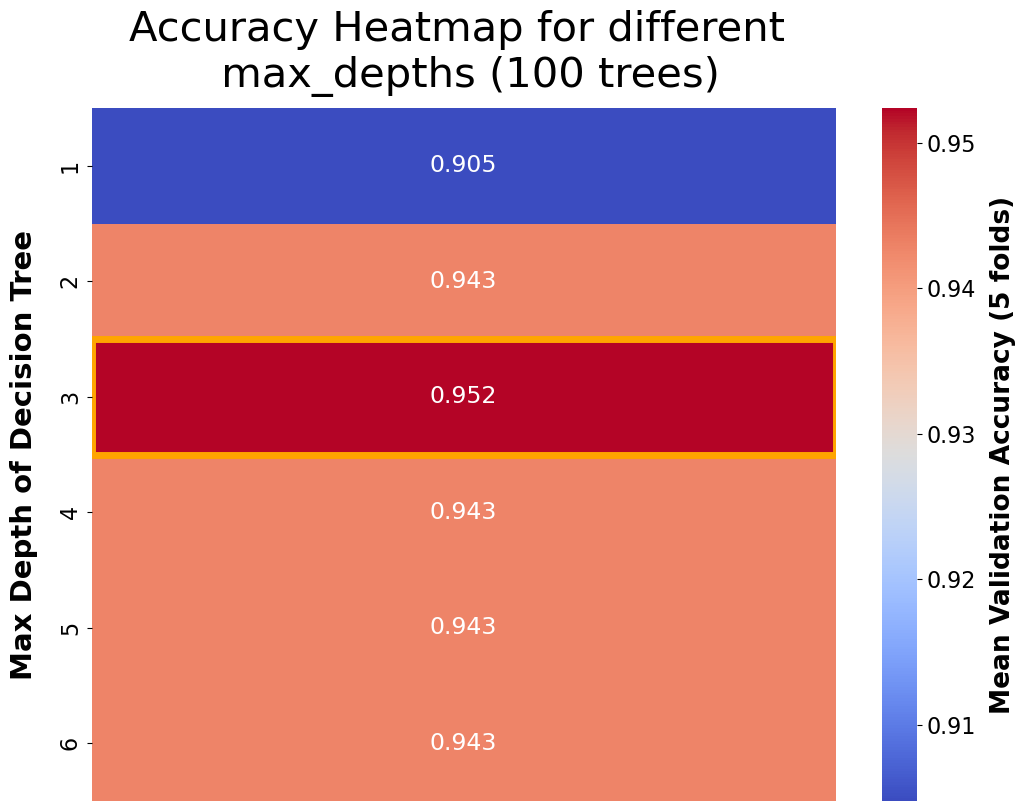

In [116]:

df_sorted = CVdataframe_RF.sort_values('param_max_depth')  # Sort by max_depth for better visualization


accuracy = df_sorted['mean_test_score']
depths = df_sorted['param_max_depth']

# Create a "flattened" heatmap
fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap([[val] for val in accuracy], ax=ax, annot=True, fmt=".3f", cmap='coolwarm', 
            yticklabels=depths, annot_kws={"size": 17})

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Mean Validation Accuracy (5 folds)', fontsize=19, labelpad = 10, fontweight = 'bold')
cbar.ax.tick_params(axis='both', labelsize = 16)

ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xticks([], [])
ax.set_title("Accuracy Heatmap for different \n max_depths (100 trees)", fontsize = 30, pad = 15)
ax.set_ylabel("Max Depth of Decision Tree", fontsize = 21, labelpad = 15, fontweight = 'bold')
ax.add_patch(plt.Rectangle((0,optimalindexRF), 1, 1, fill=False, edgecolor='orange', lw=5))
plt.savefig(PATH_1 + "/Accuracy_heatmap_RF.png",bbox_inches='tight')
plt.show()

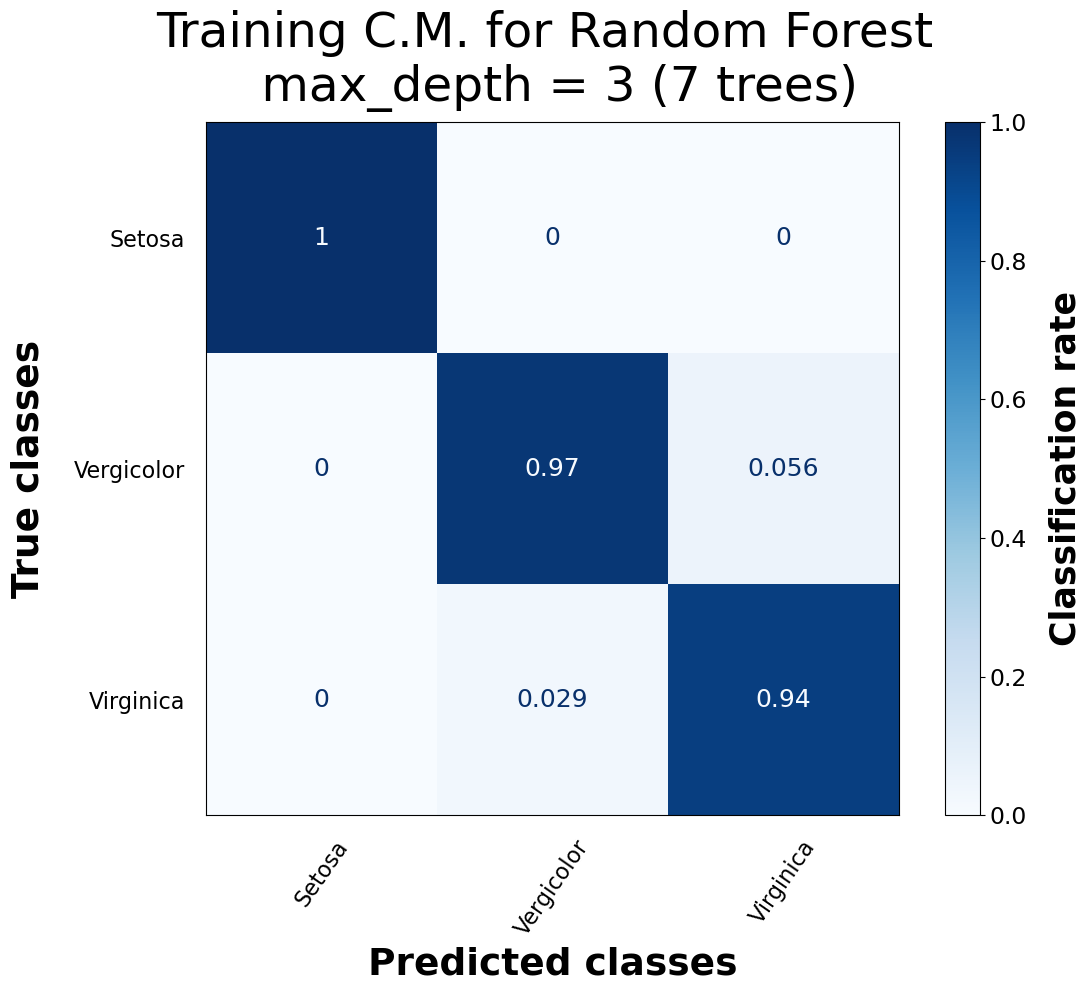

In [117]:
################## CONFUSION MATRICES ##################################################

fig0, ax0 = plt.subplots(figsize=(12, 9))

classes = ['Setosa', 'Vergicolor', 'Virginica']
# Plot training confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_train, train_predictions_RF, ax=ax0, display_labels = classes, cmap='Blues', normalize = "pred", xticks_rotation=55, text_kw = dict(fontsize = 18), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.set_ylabel('Classification rate', fontsize=25, labelpad = 15, fontweight = 'bold')
cbar.ax.tick_params(labelsize = 17)

ax0.set_title(f'Training C.M. for Random Forest \n max_depth = {optimalparamsRF[0]} ({int(optimal_estimatorsRF)} trees)', fontsize = 35, pad = 15)
ax0.tick_params(axis='both', which='both', length=0, labelsize = 16, pad = 15)
ax0.set_xlabel('Predicted classes', fontsize = 27, fontweight = 'bold')
ax0.set_ylabel('True classes', fontsize = 27, labelpad = 20, fontweight = 'bold')
plt.savefig(PATH_1 + "/Training_CM_RF.png",bbox_inches='tight')
plt.show()

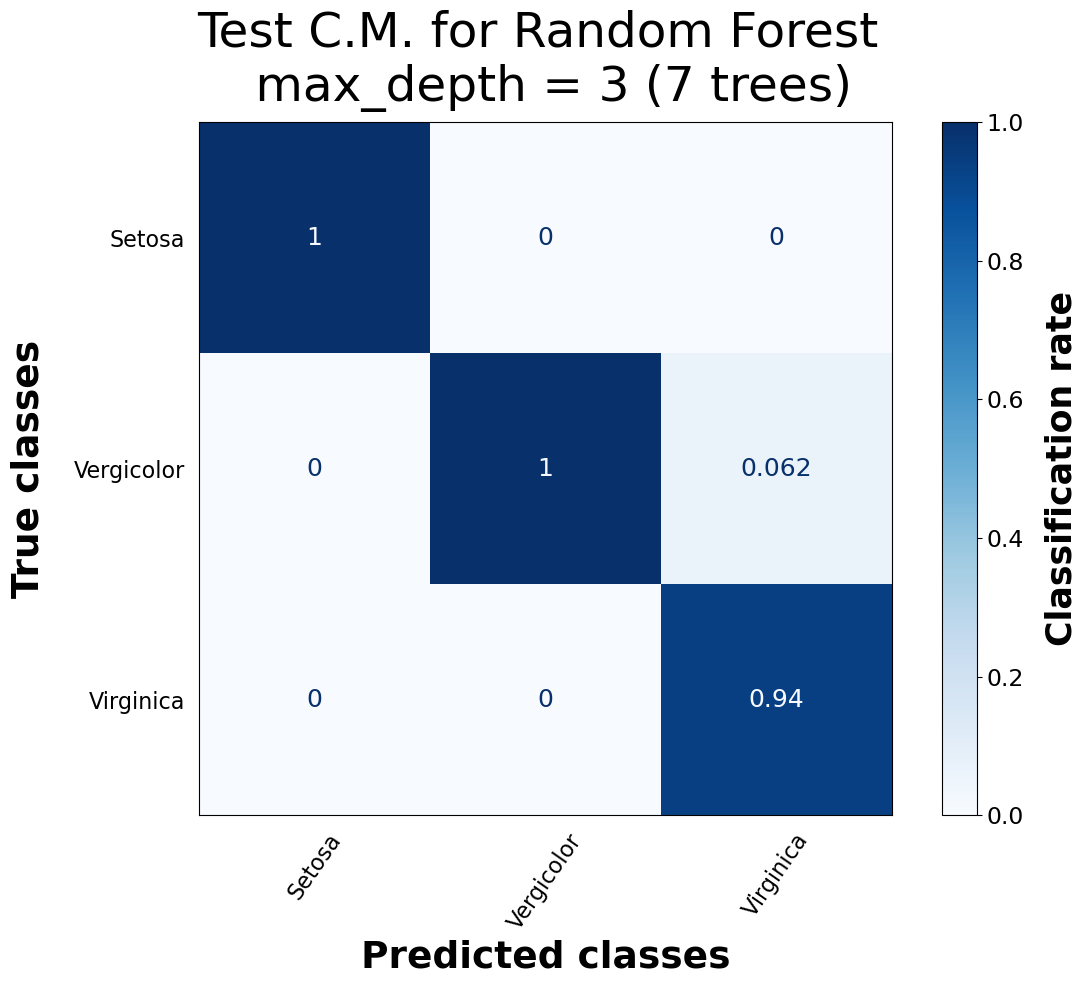

In [118]:
# Plot test confusion matrix

fig1, ax1 = plt.subplots(figsize=(13, 9))

disp = ConfusionMatrixDisplay.from_predictions(y_test, test_predictions_RF, ax=ax1, display_labels = classes, cmap='Blues', normalize = "pred", xticks_rotation=55, text_kw = dict(fontsize = 18), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.set_ylabel('Classification rate', fontsize=25, labelpad = 15, fontweight = 'bold')
cbar.ax.tick_params(labelsize = 17)

ax1.set_title(f'Test C.M. for Random Forest \n max_depth = {optimalparamsRF[0]} ({int(optimal_estimatorsRF)} trees)', fontsize = 35, pad = 15)
ax1.tick_params(axis = 'both', which = 'both', length = 0, labelsize = 16, pad = 10)
ax1.set_xlabel('Predicted classes', fontsize = 27, fontweight = 'bold')
ax1.set_ylabel('True classes', fontsize = 27, labelpad = 20, fontweight = 'bold')
plt.savefig(PATH_1 + "/Test_CM_RF.png",bbox_inches='tight')
plt.show()

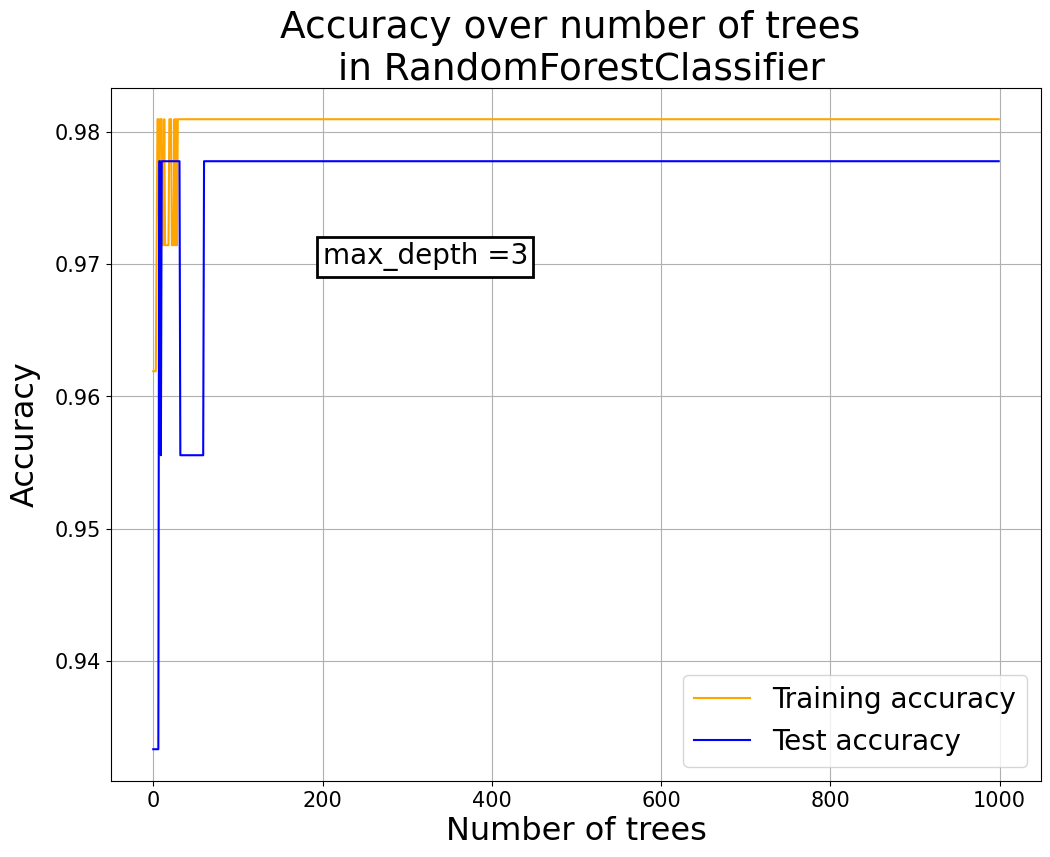

In [119]:
########################### CROSS ENTROPY AND ACCURACY OVER ESTIMATORS #######################################
plt.figure(1, figsize = (12, 9))
plt.plot(range(0,1000), train_accs_RF, color = 'orange', label = 'Training accuracy')
plt.plot(range(0,1000), test_accs_RF, color = 'blue', label = 'Test accuracy')
plt.legend(fontsize = 20)
plt.text(200, 0.97, f'max_depth ={optimalparamsRF[0]}', fontsize = 20, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.title(f'Accuracy over number of trees \n in RandomForestClassifier', fontsize = 27)
plt.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Number of trees', fontsize = 23)
plt.ylabel('Accuracy', fontsize = 23, labelpad = 10)
plt.grid()
plt.savefig(PATH_2 + "/Accuracy_over_estimators_RF.png",bbox_inches='tight')
plt.show()

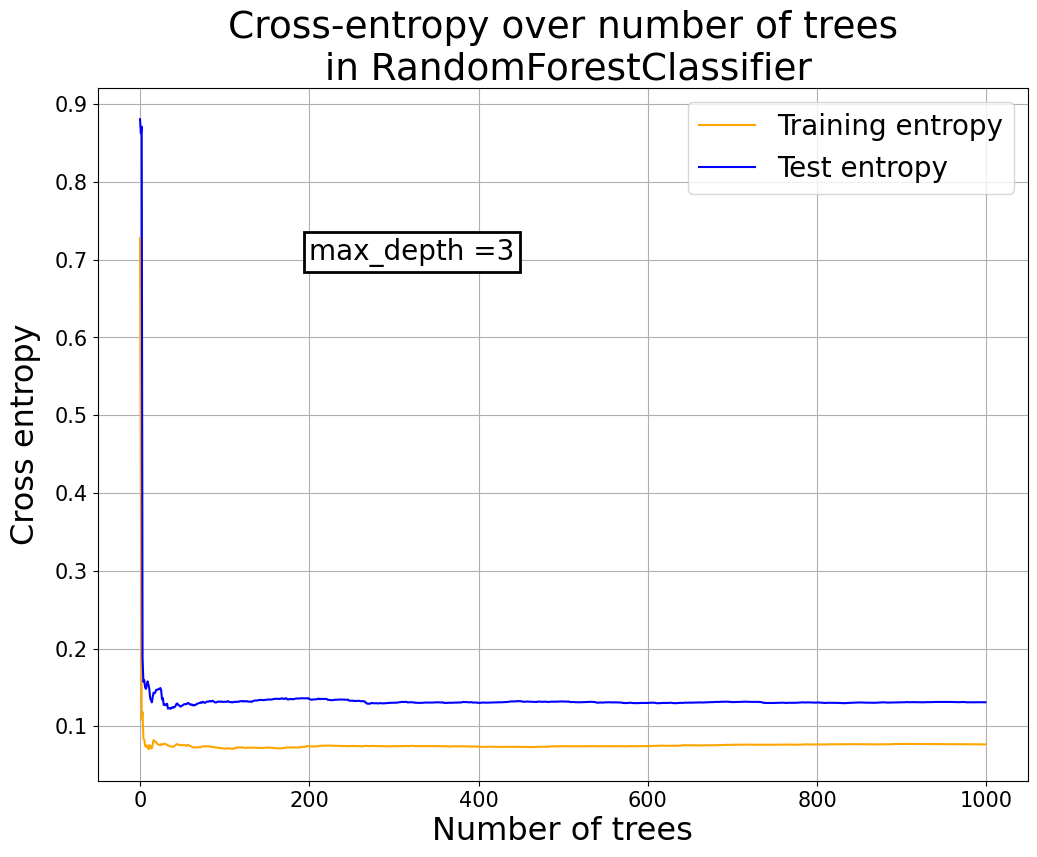

In [120]:
plt.figure(1, figsize = (12, 9))
plt.plot(range(0,1000), train_errors_RF, color = 'orange', label = 'Training entropy')
plt.plot(range(0,1000), test_errors_RF, color = 'blue', label = 'Test entropy')
plt.legend(fontsize = 20)
plt.title(f'Cross-entropy over number of trees\n in RandomForestClassifier', fontsize = 27)
plt.text(200, 0.7, f'max_depth ={optimalparamsRF[0]}', fontsize = 20, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Number of trees', fontsize = 23)
plt.ylabel('Cross entropy', fontsize = 23, labelpad = 10)
plt.grid()
plt.savefig(PATH_2 + "/Entropy_over_estimators_RF.png",bbox_inches='tight')
plt.show()

## Plots for XGBClassifier

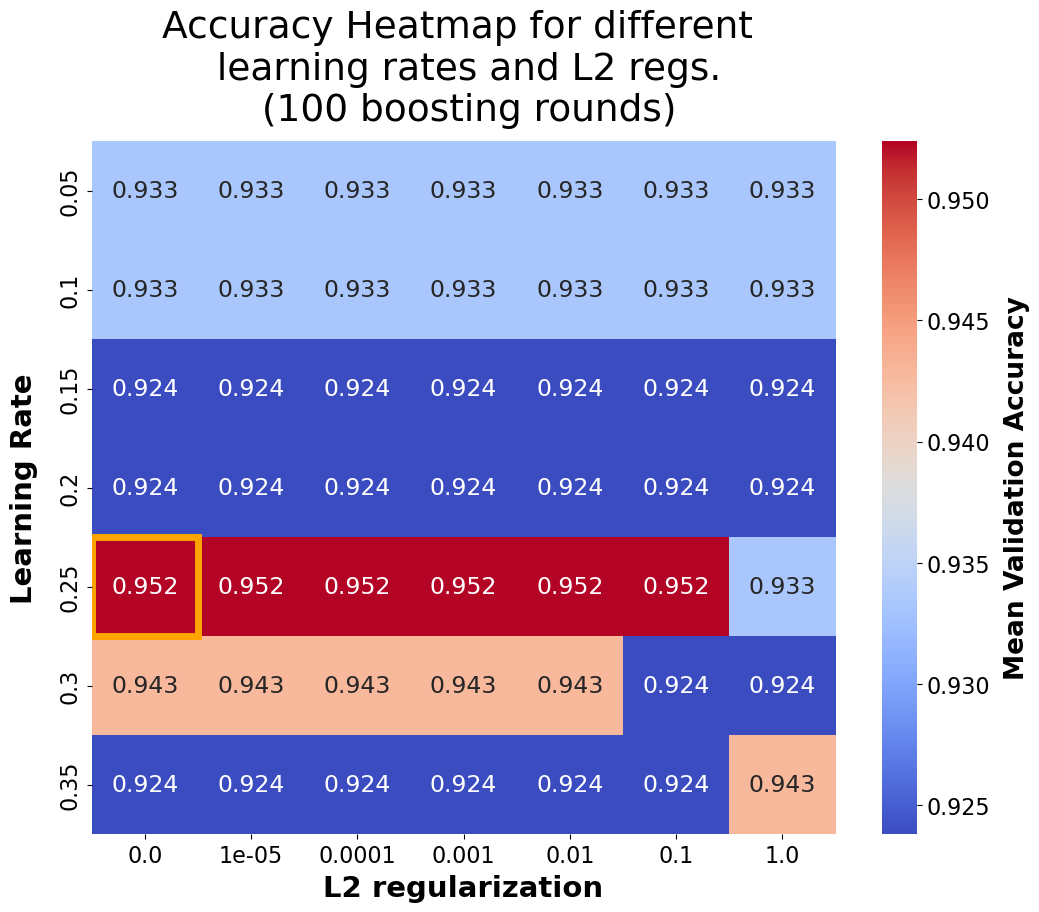

In [122]:
################### VALIDATION ACCURACY HEATMAP ######################

heatmap_data = CVdataframe_XGB.pivot(index = 'param_learning_rate', columns = 'param_reg_lambda', values = 'mean_test_score')


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(heatmap_data, ax = ax, annot=True, fmt=".3f", cmap="coolwarm", annot_kws={"size": 17})

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Mean Validation Accuracy', fontsize=19, labelpad = 10, fontweight = 'bold')
cbar.ax.tick_params(axis='both', labelsize = 16)

ax.tick_params(axis = 'both', labelsize = 16)
ax.set_title("Accuracy Heatmap for different \n learning rates and L2 regs.\n (100 boosting rounds)", fontsize = 27, pad = 15)
ax.set_xlabel("L2 regularization", fontsize = 21, labelpad = 5, fontweight = 'bold')
ax.set_ylabel("Learning Rate", fontsize = 21, labelpad = 15, fontweight = 'bold')
ax.add_patch(plt.Rectangle((optimalindexXGB[1], optimalindexXGB[0]), 1, 1, fill=False, edgecolor='orange', lw=5))
plt.savefig(PATH_3 + "/Accuracy_heatmap_XGB.png",bbox_inches='tight')
plt.show()

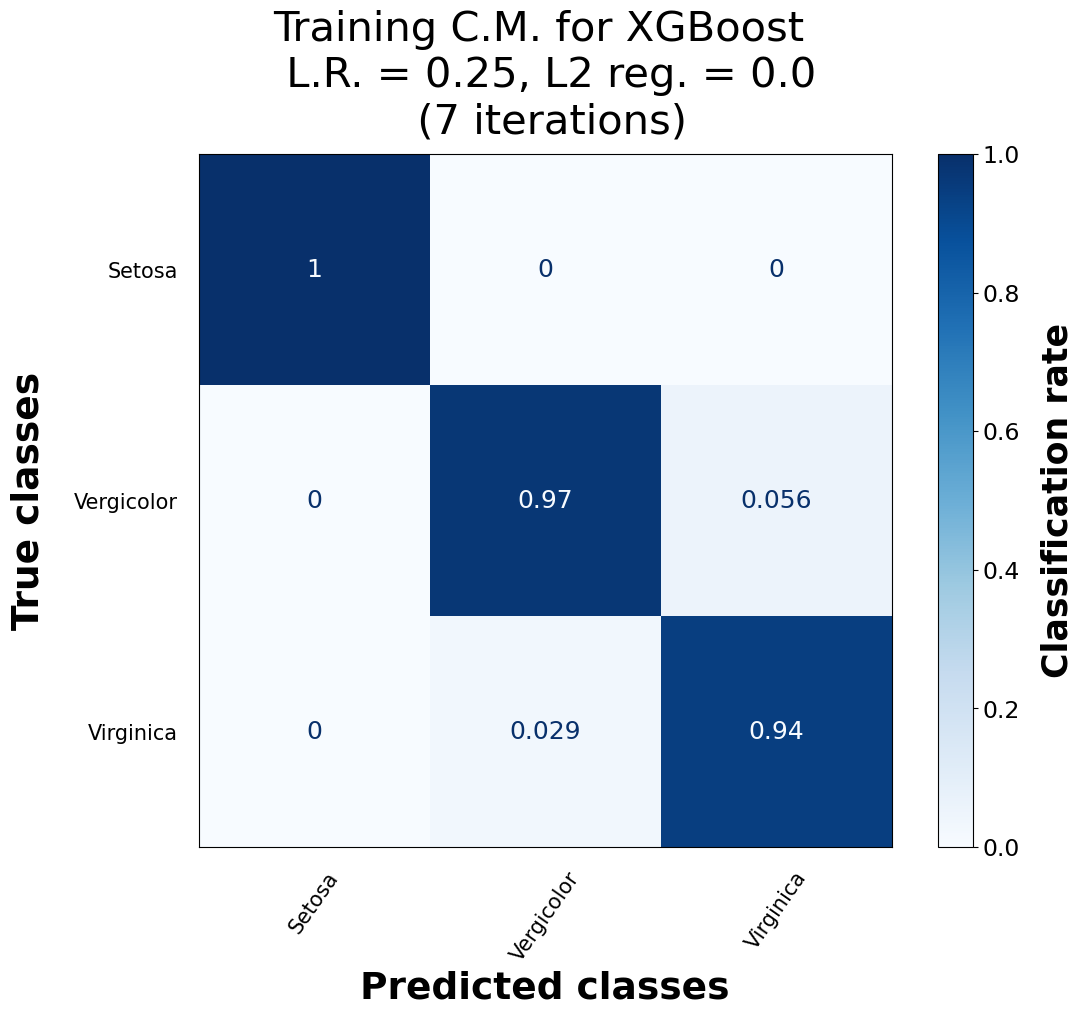

In [123]:
################## CONFUSION MATRICES ##################################################
fig0, ax0 = plt.subplots(figsize=(12, 9))

classes = ['Setosa', 'Vergicolor', 'Virginica']
# Plot training confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_train, train_predictions_XGB, ax=ax0, display_labels = classes, cmap='Blues', normalize = "pred", xticks_rotation=55, text_kw = dict(fontsize = 18), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.set_ylabel('Classification rate', fontsize=25, labelpad = 15, fontweight = 'bold')
cbar.ax.tick_params(labelsize = 17)

ax0.set_title(f'Training C.M. for XGBoost \n L.R. = {optimalparamsXGB[0]}, L2 reg. = {optimalparamsXGB[1]}\n ({int(optimal_iterationXGB)} iterations)', fontsize = 30, pad = 15)
ax0.tick_params(axis='both', which='both', length=0, labelsize = 15, pad = 15)
ax0.set_xlabel('Predicted classes', fontsize = 27, fontweight = 'bold')
ax0.set_ylabel('True classes', fontsize = 27, labelpad = 20, fontweight = 'bold')
plt.savefig(PATH_3 + "/Training_CM_XGB.png",bbox_inches='tight')
plt.show()

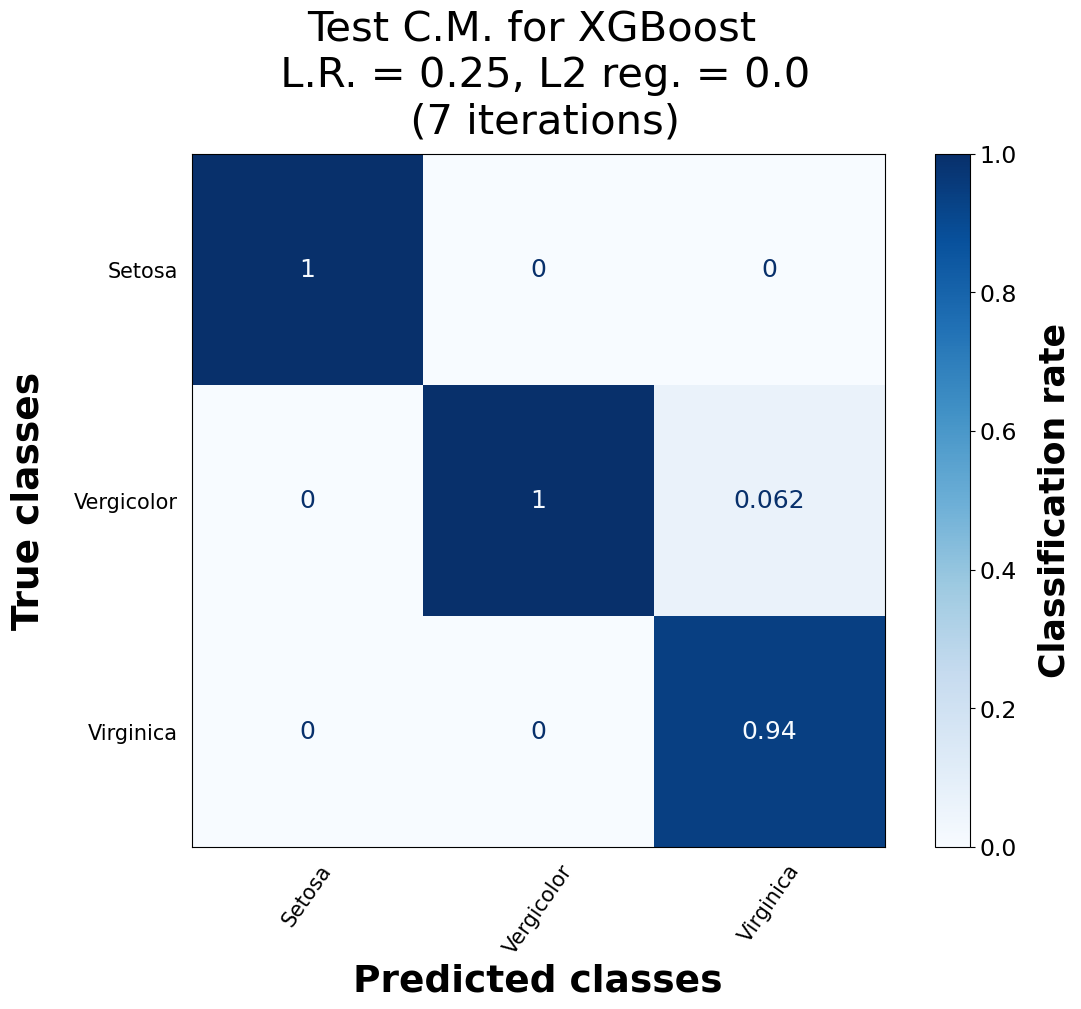

In [124]:
fig1, ax1 = plt.subplots(figsize=(13, 9))

disp = ConfusionMatrixDisplay.from_predictions(y_test, test_predictions_XGB, ax=ax1, display_labels = classes, cmap='Blues', normalize = "pred", xticks_rotation=55, text_kw = dict(fontsize = 18), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.set_ylabel('Classification rate', fontsize=25, labelpad = 15, fontweight = 'bold')
cbar.ax.tick_params(labelsize = 17)

ax1.set_title(f'Test C.M. for XGBoost \n L.R. = {optimalparamsXGB[0]}, L2 reg. = {optimalparamsXGB[1]}\n ({int(optimal_iterationXGB)} iterations)', fontsize = 30, pad = 15)
ax1.tick_params(axis = 'both', which = 'both', length = 0, labelsize = 15, pad = 10)
ax1.set_xlabel('Predicted classes', fontsize = 27, fontweight = 'bold')
ax1.set_ylabel('True classes', fontsize = 27, labelpad = 20, fontweight = 'bold')
plt.savefig(PATH_3 + "/Test_CM_XGB.png",bbox_inches='tight')
plt.show()

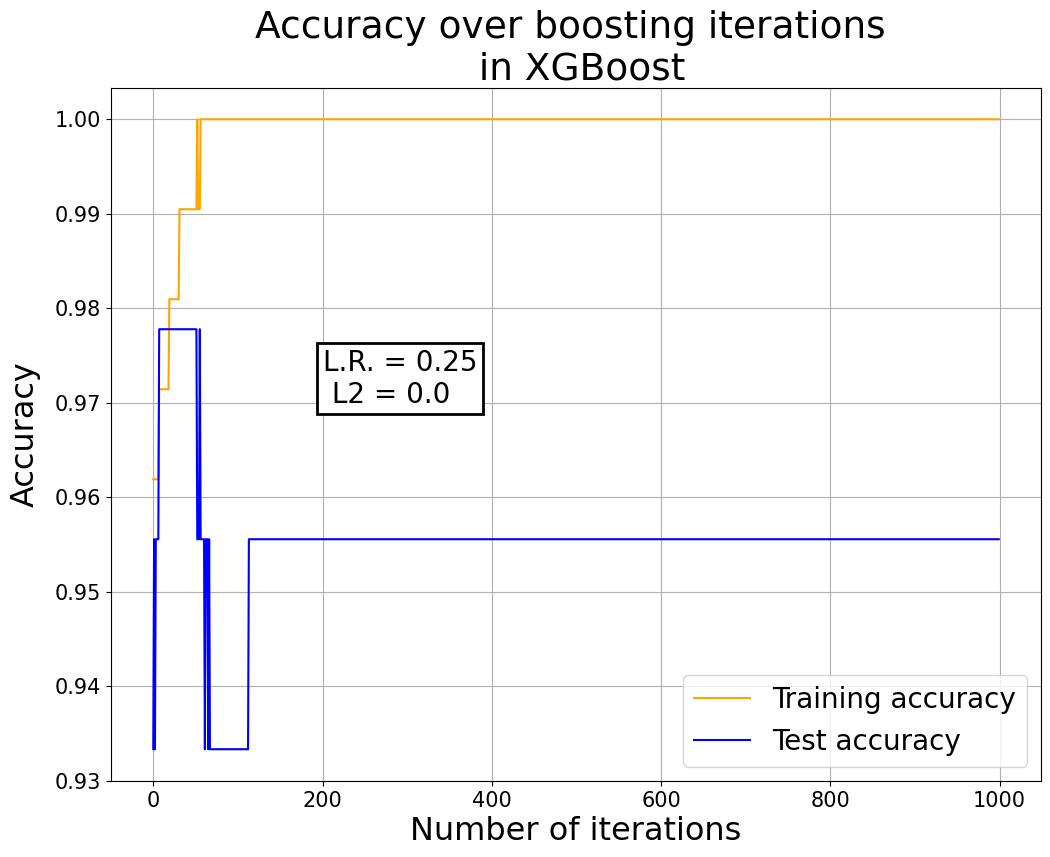

In [125]:
########################### CROSS ENTROPY AND ACCURACY OVER ROUNDS #######################################
plt.figure(1, figsize = (12, 9))
plt.plot(range(0,1000), train_accs_XGB, color = 'orange', label = 'Training accuracy')
plt.plot(range(0,1000), test_accs_XGB, color = 'blue', label = 'Test accuracy')
plt.legend(fontsize = 20)
plt.title(f'Accuracy over boosting iterations \n in XGBoost', fontsize = 27)
plt.text(200, 0.97, f'L.R. = {optimalparamsXGB[0]}\n L2 = {optimalparamsXGB[1]}', fontsize = 20, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Number of iterations', fontsize = 23)
plt.ylabel('Accuracy', fontsize = 23, labelpad = 10)
plt.grid()
plt.savefig(PATH_4 + "/Accuracy_over_estimators_XGB.png", bbox_inches='tight')
plt.show()

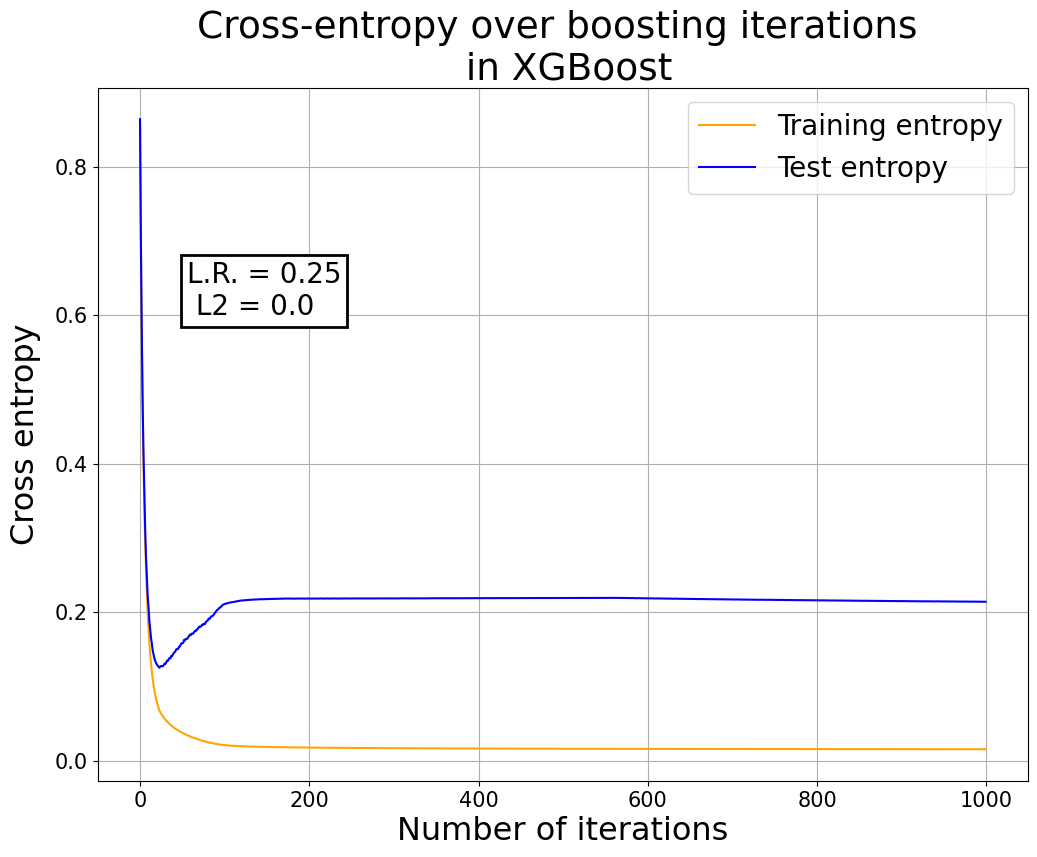

In [126]:
plt.figure(1, figsize = (12, 9))
plt.plot(range(0,1000), train_errors_XGB, color = 'orange', label = 'Training entropy')
plt.plot(range(0,1000), test_errors_XGB, color = 'blue', label = 'Test entropy')
plt.legend(fontsize = 20)
plt.title(f'Cross-entropy over boosting iterations \n in XGBoost', fontsize = 27)
plt.text(55, 0.6, f'L.R. = {optimalparamsXGB[0]}\n L2 = {optimalparamsXGB[1]}', fontsize = 20, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Number of iterations', fontsize = 23)
plt.ylabel('Cross entropy', fontsize = 23, labelpad = 10)
plt.grid()
plt.savefig(PATH_4 + "/Entropy_over_estimators_XGB.png",bbox_inches='tight')
plt.show()